In [1]:
#Created by Rekha Sundararajan
# Fan Degradation prediction using the NASA public dataset provided for TurboFan Engine data that has both HPC and Fan degradation and HPC only degradation.
#Import required Libraries
import pandas as pd
import numpy as np
import random
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(34)

In [2]:
# Retrieve the given data into the dataframe for analysis. 
# The given dataset consists of FD001 and FD003 for train, test and separate test file for RUL (Remaining useful life last cycle as for the test data the data is not provided till failure unlike training dataset.)
# FD001 and FD003 dataset were provided for sealevel condition only and FD001 data contains engine failure due to HPC degradation only and FD003 contains for both HPC and Fan degradation.
index_names=['unit_number','time_cycles']
setting_names = ['setting_1','setting_2','setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(21)]
col_names  = index_names + setting_names + sensor_names

# train dataset is provided for until the failure timecycle.
dftrain1 = pd.read_csv("train_FD001.txt",sep="\s+",header=None,index_col=False,names=col_names)
dftrain3 = pd.read_csv("train_FD003.txt",sep="\s+",header=None,index_col=False,names=col_names)

#Test dataset provided way before failure
dftest1 = pd.read_csv("test_FD001.txt",sep="\s+",header=None,index_col=False,names=col_names)
dftest3 = pd.read_csv("test_FD003.txt",sep="\s+",header=None,index_col=False,names=col_names)

# for the given testdataset for each engine identified by unit number the remaining time cycle is provided so that this can be added up to the test data to create the RUL label as test data is before failure.
y_test1 = pd.read_csv("RUL_FD001.txt",sep="\s+",header=None,index_col=False,names=['lastcycle'])
y_test3 = pd.read_csv("RUL_FD003.txt",sep="\s+",header=None,index_col=False,names=['lastcycle'])


In [3]:
# create a deep copy so that a back up for original is retained.
train1 = dftrain1.copy()
train3 = dftrain3.copy()


In [4]:
# Define a function to add a new Efficiency column. The data for train contains till failure and so the last cycle is considered the max time cycle upto which engine was functioning.
# based on this efficiency is calculated per cycle as a difference from max.
def add_EFFICIENCY_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycles'),left_on='unit_number',right_index=True)
    merged['EFFICIENCY'] = 100*((merged['max_time_cycles'] - merged['time_cycles'])/merged['max_time_cycles'])
    merged = merged.drop("max_time_cycles",axis=1)
    return merged



In [5]:
# add the efficiency column to the training dataset.
train1 = add_EFFICIENCY_column(train1)
train3 = add_EFFICIENCY_column(train3)


In [6]:
# For the given NASA public dataset 21 sensor data have been provided and created a below dictionary to denote what each sensor refers to.
Sensor_dictionary = {}
dict_list=[
    "Fan Inlet Temperature",
    "LPC Outlet Temperature",
    "HPC Outlet Temperature",
    "LPT Outlet Temperature",
    "Fan Inlet Pressure",
    "Bypass-duct Pressure",
    "HPC Outlet Pressure",
    "Physical Fan Speed",
    "Physical Core Speed",
    "Engine pressure ratio",
    "HPC Outlet Static Pressure",
    "Ratio of Fuel Flow to PS30",
    "Corrected Fan Speed",
    "Corrected Core Speed",
    "Bypass ratio",
    "Burner Fuel-air Ratio",
    "Bleed Enthalpy",
    "Required Fan Speed",
    "Required Fan Conversion Speed",
    "High-pressure turbines cool air flow",
    "Low-pressure turbines cool air flow"
]

si = 1
for x in dict_list:
    Sensor_dictionary['s_'+str(si)] = x
    si += 1
Sensor_dictionary

{'s_1': 'Fan Inlet Temperature',
 's_2': 'LPC Outlet Temperature',
 's_3': 'HPC Outlet Temperature',
 's_4': 'LPT Outlet Temperature',
 's_5': 'Fan Inlet Pressure',
 's_6': 'Bypass-duct Pressure',
 's_7': 'HPC Outlet Pressure',
 's_8': 'Physical Fan Speed',
 's_9': 'Physical Core Speed',
 's_10': 'Engine pressure ratio',
 's_11': 'HPC Outlet Static Pressure',
 's_12': 'Ratio of Fuel Flow to PS30',
 's_13': 'Corrected Fan Speed',
 's_14': 'Corrected Core Speed',
 's_15': 'Bypass ratio',
 's_16': 'Burner Fuel-air Ratio',
 's_17': 'Bleed Enthalpy',
 's_18': 'Required Fan Speed',
 's_19': 'Required Fan Conversion Speed',
 's_20': 'High-pressure turbines cool air flow',
 's_21': 'Low-pressure turbines cool air flow'}

In [7]:
#define a function to plot each sensor time series data against efficiency per engine.There are about 100 engine data provided for test and train.
def plot_signal(df,sensor_dic,signal_name,tlabel):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():  
        #if i%10 == 0:
            plt.plot('EFFICIENCY',signal_name,data=df[df['unit_number'] == i].rolling(10).mean())
    plt.xlim(100,0)
    plt.xticks(np.arange(0,100,5))
    plt.ylabel(sensor_dic[signal_name])
    plt.xlabel('Efficiency')
    plt.title(tlabel)
    plt.show()

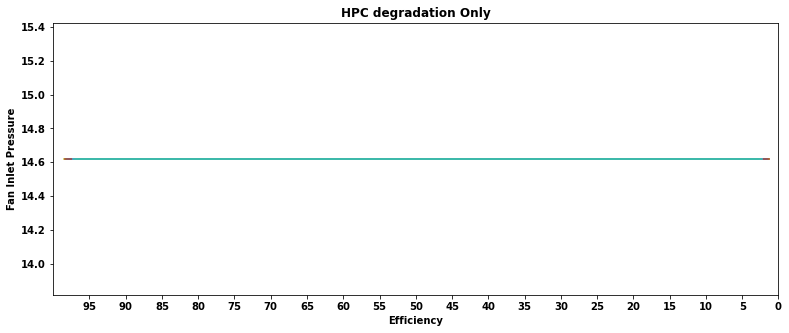

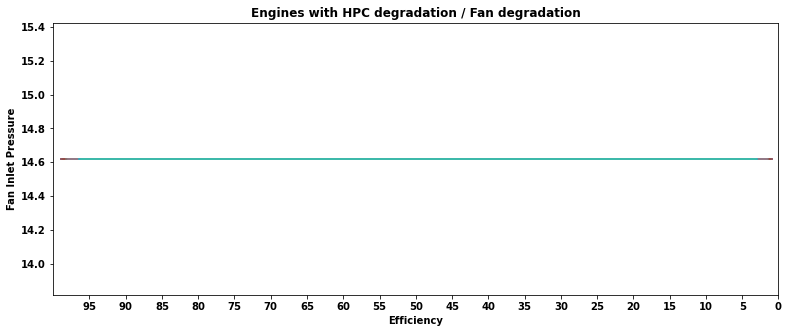

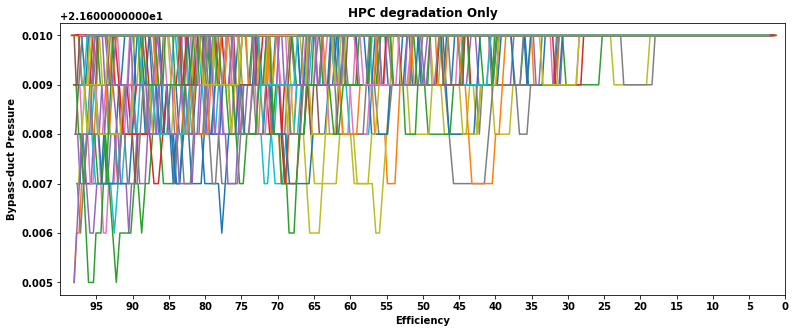

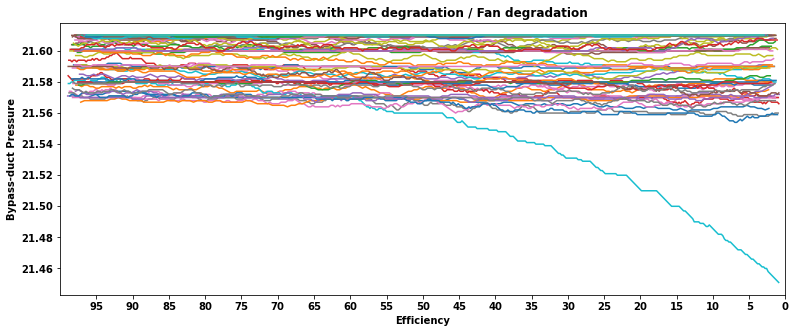

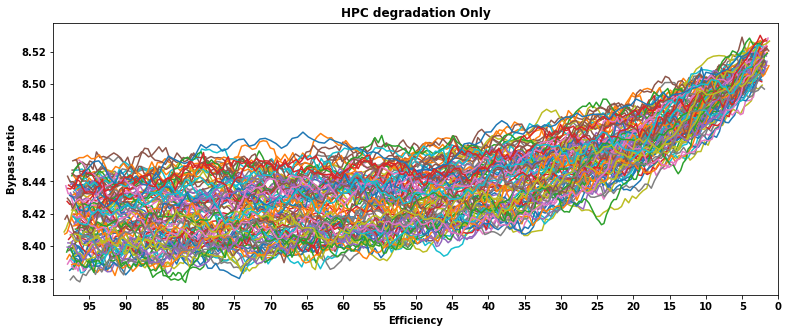

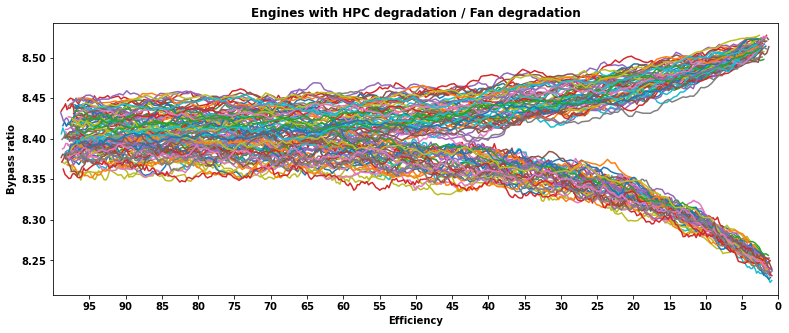

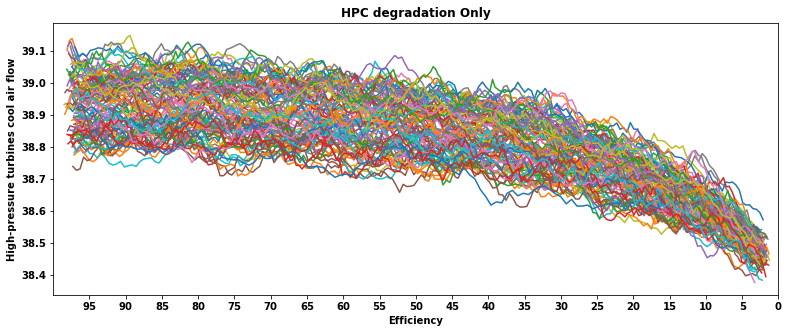

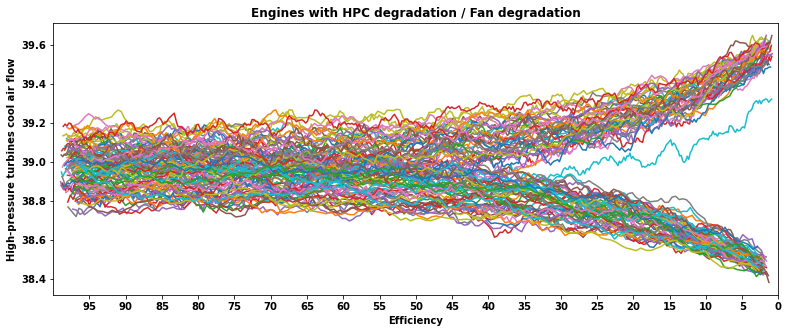

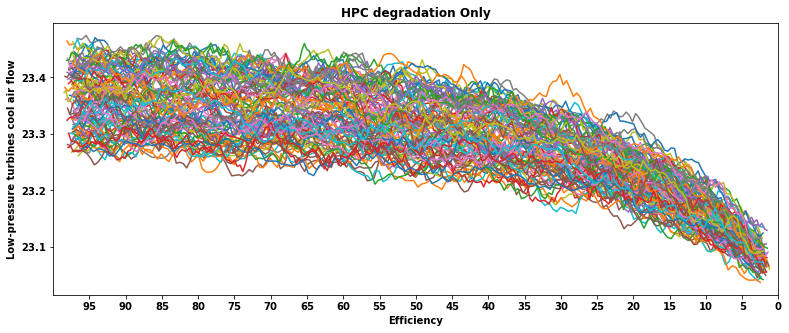

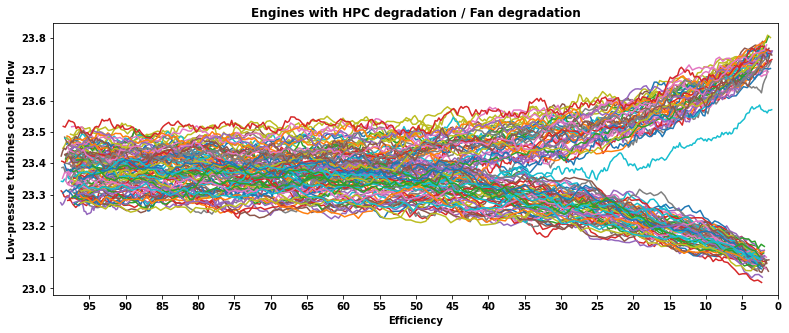

In [8]:
# call the plot signal function above to visualize the sensor data.
s=[5,6,15,20,21]#21,7,8,9,13,14,15]
for j in range(0,len(s)):
    try:
        plot_signal(train1,Sensor_dictionary,'s_'+str(s[j]),'HPC degradation Only')
        plot_signal(train3,Sensor_dictionary,'s_'+str(s[j]),'Engines with HPC degradation / Fan degradation')
    except:
        pass

In [9]:
#RS: The FD001 data is provided for HPC degradation mode only and FD003 is provided for both HPC and Fan degradation and so based on above plots filter out those patterns that donot follow the FD001 data from FD003 to identify hpc degradation specific engines and use those for training.
def fandegunitNumList(df):
    # use the HPC outlet pressure deviation > 6 as to have fan degradation specific engines as this dataset has both hpc and fan deg as those deviations less than 6 follows the same pattern as in FD001 that are HPC degradation only.
    
    train_grouped_by_unit = df.groupby(by='unit_number')
    maxs7 = train_grouped_by_unit['s_7'].max()
    mins7 = train_grouped_by_unit['s_7'].min()
    diffce = maxs7 - mins7
    merged = df.merge(diffce.to_frame(name='diffce'),left_on='unit_number',right_index=True)
    
    return merged[merged['diffce'] <= 6]['unit_number'].unique()


In [10]:
#RS: Based on give dataset define the fandegradation label as 0 for those with HPC degradtion only and 1 for those with both HPC and fan. But since the data from HPC and fan will be filtered for fan degradation specific engines 1 will represent those only due to Fan degradation.

train_hpc =  train3[train3['unit_number'].isin(fandegunitNumList(train3))]


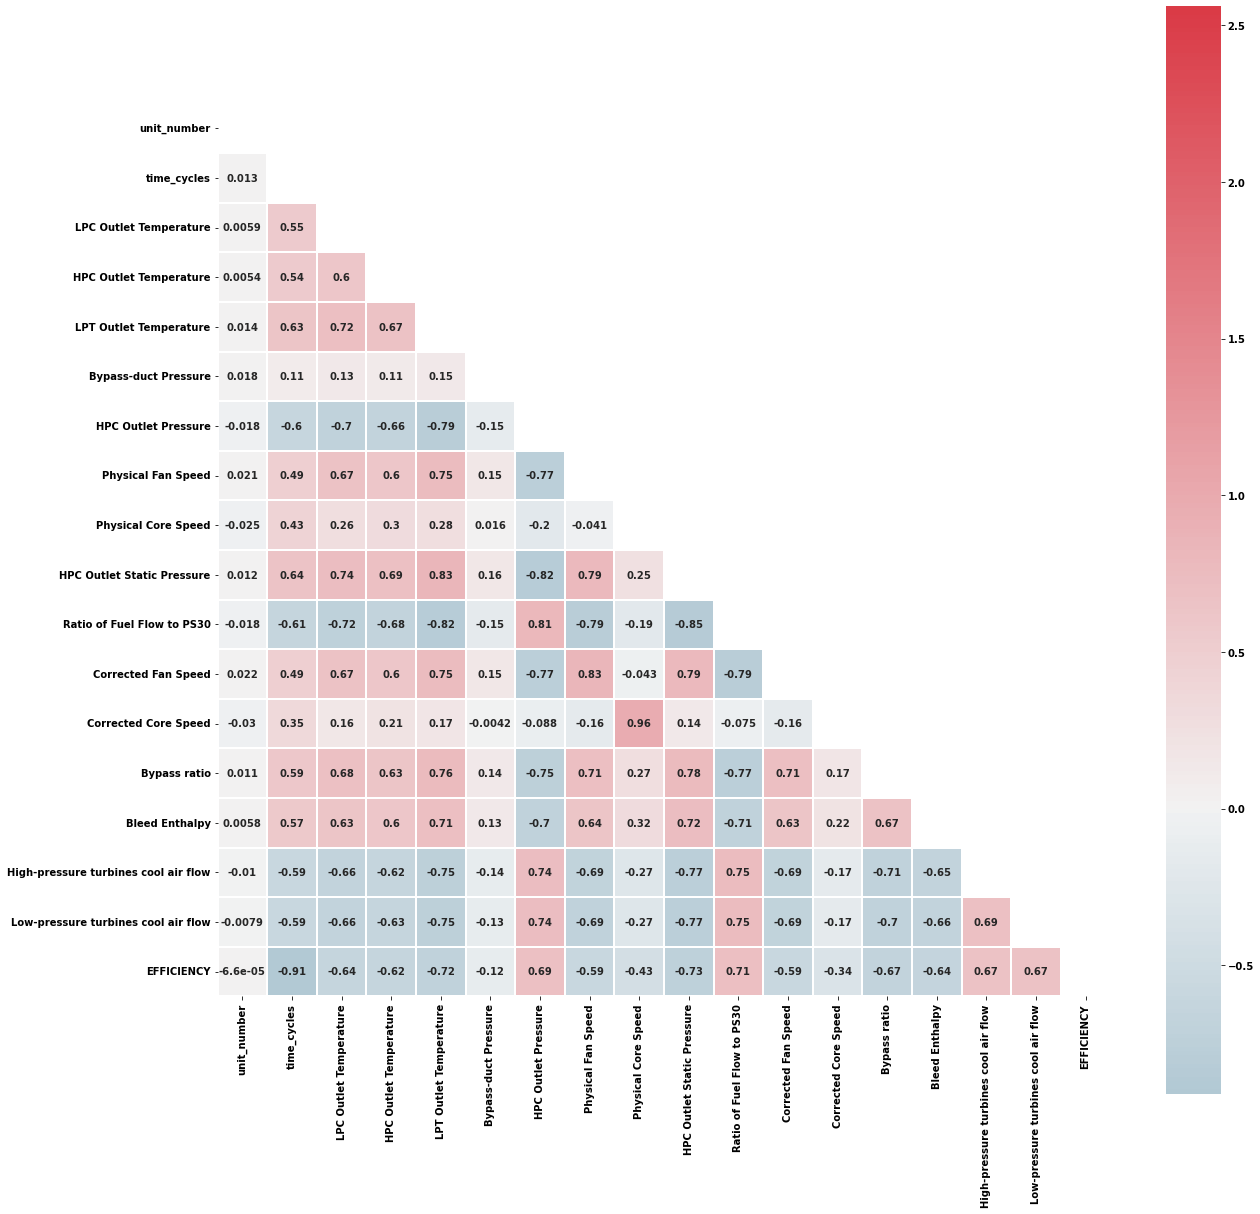

In [11]:
# RS: Using Correlation find the sensor data that are highly correlating to identifying the engine degradation due to hpc degradation 
train = pd.concat([train1,train_hpc])
train = train.rename(columns=Sensor_dictionary)
train.drop(columns=['setting_1','setting_2','setting_3','Engine pressure ratio','Fan Inlet Temperature','Burner Fuel-air Ratio','Required Fan Speed','Fan Inlet Pressure','Required Fan Conversion Speed'],inplace=True)
corr = train.corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
f,ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230,10,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=2.56,center=0,square=True,linewidths=0.4,annot=True)#cbar_kws={"shrink":0.5})
plt.gcf().set_size_inches(20, 20)
plt.show()



In [12]:
Sensor_dictionary

{'s_1': 'Fan Inlet Temperature',
 's_2': 'LPC Outlet Temperature',
 's_3': 'HPC Outlet Temperature',
 's_4': 'LPT Outlet Temperature',
 's_5': 'Fan Inlet Pressure',
 's_6': 'Bypass-duct Pressure',
 's_7': 'HPC Outlet Pressure',
 's_8': 'Physical Fan Speed',
 's_9': 'Physical Core Speed',
 's_10': 'Engine pressure ratio',
 's_11': 'HPC Outlet Static Pressure',
 's_12': 'Ratio of Fuel Flow to PS30',
 's_13': 'Corrected Fan Speed',
 's_14': 'Corrected Core Speed',
 's_15': 'Bypass ratio',
 's_16': 'Burner Fuel-air Ratio',
 's_17': 'Bleed Enthalpy',
 's_18': 'Required Fan Speed',
 's_19': 'Required Fan Conversion Speed',
 's_20': 'High-pressure turbines cool air flow',
 's_21': 'Low-pressure turbines cool air flow'}

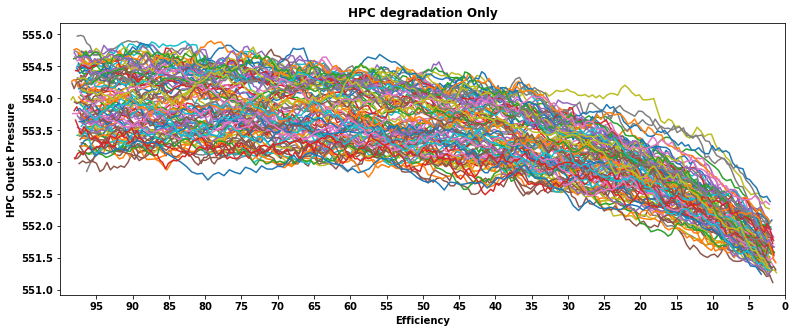

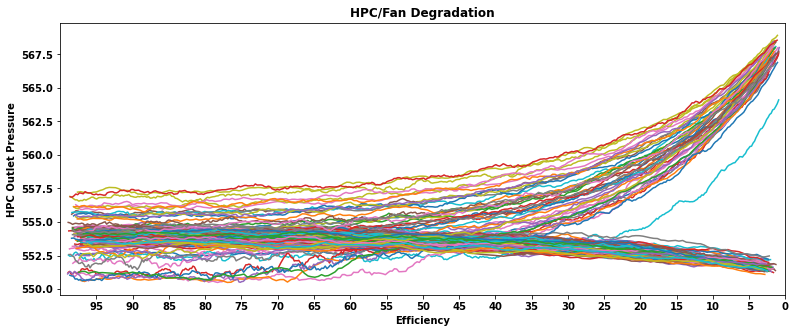

In [13]:
#s=[13,8]#7,6,12,15,20,21]
s=[7]
for j in range(0,len(s)):
    try:
        plot_signal(train1,Sensor_dictionary,'s_'+str(s[j]),'HPC degradation Only')        
        plot_signal(train3,Sensor_dictionary,'s_'+str(s[j]),'HPC/Fan Degradation')
        plot_signal(train_fan,Sensor_dictionary,'s_'+str(s[j]),'Filtered Fan degradation only engines from train3 data')
        plot_signal(train_hpc,Sensor_dictionary,'s_'+str(s[j]),'Filtered HPC degradation only engines from train3 data')
    except:
        pass

In [14]:
corr[corr['EFFICIENCY'] > 0.5]['EFFICIENCY'].sort_values()

Low-pressure turbines cool air flow     0.666854
High-pressure turbines cool air flow    0.666998
HPC Outlet Pressure                     0.691427
Ratio of Fuel Flow to PS30              0.706150
EFFICIENCY                              1.000000
Name: EFFICIENCY, dtype: float64

In [15]:
corr[corr['EFFICIENCY'] < -0.5]['EFFICIENCY'].sort_values()

time_cycles                  -0.909623
HPC Outlet Static Pressure   -0.731383
LPT Outlet Temperature       -0.716301
Bypass ratio                 -0.674846
Bleed Enthalpy               -0.644321
LPC Outlet Temperature       -0.635803
HPC Outlet Temperature       -0.615905
Corrected Fan Speed          -0.585462
Physical Fan Speed           -0.585043
Name: EFFICIENCY, dtype: float64

In [16]:
def add_EFFICIENCY_column_fortest(df,ytest):
    train_grouped_by_unit = df.groupby(by='unit_number')
    ytest.index =np.arange(df['unit_number'].min(),len(ytest)+df['unit_number'].min())
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() + ytest
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycles'),left_on='unit_number',right_index=True)
    merged['EFFICIENCY'] = 100*((merged['max_time_cycles'] - merged['time_cycles'])/merged['max_time_cycles'])
    merged = merged.drop("max_time_cycles",axis=1)
    return merged

test1 = dftest1.copy()
test1 = add_EFFICIENCY_column_fortest(test1,y_test1['lastcycle'])
#test3['fan_degradation'] = 1


In [17]:
# using the top correlating features to the engine efficiency for the HPC degradation only data for model prediction.
features = ['unit_number','time_cycles','s_2','s_7','s_11','s_12','s_15']
target = ['EFFICIENCY']
#train_fan3 = train3[train3['unit_number'].isin(fandegunitNumList(train3))]
x_train = train_hpc[features]#pd.concat([train1[features],train_fan3[features]])
y_train = train_hpc[target]#train_fan3[target]#pd.concat([train1[target],train_fan3[target]])
#from sklearn.preprocessing import MinMaxScaler,StandardScaler
#scaler=StandardScaler()#MinMaxScaler()
#x_train_scaled = scaler.fit_transform(x_train)


Mean Absolute Error (MAE): 2.7169320529248977
Root Mean Squared Error (RMSE): 3.8527012785515904
R² Score: 0.9827160723833712


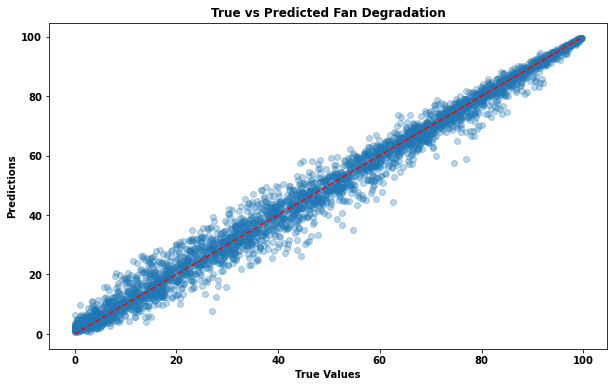

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.3,random_state=42)

#x_test_scaled = scaler.fit_transform(x_test)
# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=110, random_state=42)
rf_regressor.fit(x_train, y_train)
#!pip install xgboost
#import xgboost
#xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02,gamma=0,subsample=0.8,colsample_bytree=0.5,max_depth=3)
#xgb.fit(x_train_scaled,y_train)


# Make predictions
y_pred = rf_regressor.predict(x_test)
#y_pred = xgb.predict(x_test_scaled)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Fan Degradation')
plt.show()





Mean Absolute Error (MAE): 5.522148059341079
Root Mean Squared Error (RMSE): 8.008177834262955
R² Score: 0.8788539275782321


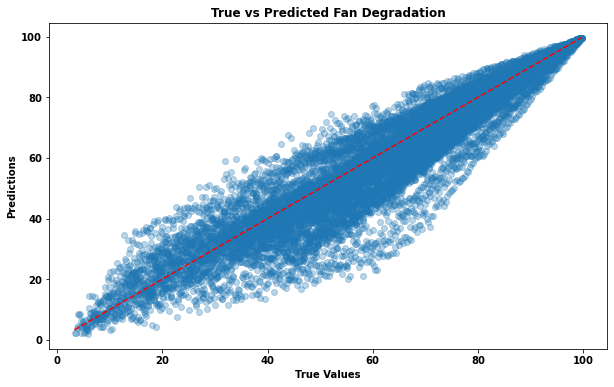

In [19]:

test_hpc = test1[test1['unit_number'].isin(fandegunitNumList(test1))]
x_test = test_hpc[features]
y_test = test_hpc[target]
# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=110, random_state=42)
rf_regressor.fit(x_train, y_train)


# Make predictions
y_pred = rf_regressor.predict(x_test)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Fan Degradation')
plt.show()



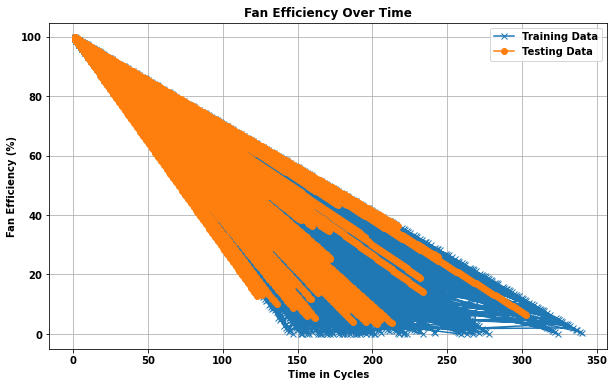

In [20]:
# Plot fan efficiency over time
plt.figure(figsize=(10, 6))
plt.plot(x_train['time_cycles'], y_train['EFFICIENCY'], marker='x', label='Training Data')
plt.plot(x_test['time_cycles'], y_test['EFFICIENCY'], marker='o', label='Testing Data')
plt.xlabel('Time in Cycles')
plt.ylabel('Fan Efficiency (%)')
plt.title('Fan Efficiency Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print("Engines used for training the model that are considered to have HPC degradation only: \n" ,train_hpc['unit_number'].unique())
#[  1   3  20  21  23  24  30  39  40  46  62  64  71  72  75  77  78  81
 # 82  92  94  99 100]
lst = train_hpc['unit_number'].unique()
print("total engines considered for training:",int(len(lst)*0.7))
print("total engines considered for testation:",int(len(lst)*0.3))
for i in range(len(lst)):   
   print("Number of cycles provided until failure for Engine with id ",lst[i]," is ",len(train_hpc[features+target][train_hpc['unit_number'] == lst[i]]))

Engines used for training the model that are considered to have HPC degradation only: 
 [  1   3   4   5   6   8  12  13  14  15  22  23  25  26  28  29  30  31
  32  35  36  40  44  47  48  50  51  52  53  54  56  58  61  63  64  65
  66  67  68  69  70  74  76  78  79  80  83  86  87  90  91  92  93  95
  99 100]
total engines considered for training: 39
total engines considered for testation: 16
Number of cycles provided until failure for Engine with id  1  is  259
Number of cycles provided until failure for Engine with id  3  is  222
Number of cycles provided until failure for Engine with id  4  is  272
Number of cycles provided until failure for Engine with id  5  is  213
Number of cycles provided until failure for Engine with id  6  is  278
Number of cycles provided until failure for Engine with id  8  is  267
Number of cycles provided until failure for Engine with id  12  is  170
Number of cycles provided until failure for Engine with id  13  is  185
Number of cycles provided un

In [22]:
print("Note: (The id used in training and test are different and donot represent the same engine.\n These are just numbers to identify different engines.)")
print("Engines used for testing the model that are considered to have HPC degradation only: \n" ,test_hpc['unit_number'].unique())
#[  1   3  20  21  23  24  30  39  40  46  62  64  71  72  75  77  78  81
 # 82  92  94  99 100]
lst = test_hpc['unit_number'].unique()
print("total engines considered for testing:",len(lst))
for i in range(len(lst)):   
   print("Number of cycles provided before failure for Engine with id ",lst[i]," is ",len(test_hpc[features+target][test_hpc['unit_number'] == lst[i]]))

Note: (The id used in training and test are different and donot represent the same engine.
 These are just numbers to identify different engines.)
Engines used for testing the model that are considered to have HPC degradation only: 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
total engines considered for testing: 100
Number of cycles provided before failure for Engine with id  1  is  31
Number of cycles provided before failure for Engine with id  2  is  49
Number of cycles provided before failure for Engine with id  3  is  126
Number of cycles provided before failure for Engine with id  4  is  106
Number of cycles provided befor